<a href="https://colab.research.google.com/github/xiaomeng-ma/Input-Pronoun/blob/master/Pronoun_Model_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

In [ ]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import tensorflow as tf
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus.reader import CHILDESCorpusReader
import numpy as np
import pandas as pd
from pandas import DataFrame
from nltk.probability import FreqDist
import string
from nltk.stem.wordnet import WordNetLemmatizer

import matplotlib.pyplot as plt
from scipy import stats
import itertools

from scipy import optimize
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import log as ln
import tensorflow_addons as tfa

import numpy
import math
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Embedding, TimeDistributed
from keras.layers import Conv1D,Conv2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.ticker as ticker
from sklearn.model_selection import StratifiedKFold,train_test_split

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import gensim


#**First model: Using all the samples** (24889 tokens)





In [ ]:
#import data 
file = '/content/drive/My Drive/QP2/Input Model/df24889.csv'
df = pd.read_csv(file)
df = shuffle(df)
df.head()

,Unnamed: 0,file,a,a_tag,X,X_tag,b,b_tag,grammar cateogry,encode_cat,encode_pos,name,encoded_case,aXb
19161,20532,Anne/020301.xml,S,/s,I,pro:sub,don't,mod~neg,NOUN,6,84,Anne,2,S_don't
12379,15646,Anne/011104.xml,eating,part,them,pro:obj,E,/e,NOUN,6,72,Anne,1,eating_E
18979,14549,Nina/020524.xml,let,v,me,pro:obj,see,v,NOUN,6,72,Nina,1,let_see
9662,21107,Eve/010800.xml,on,prep,your,det:poss,stool,n,DET,4,25,Eve,0,on_stool
24807,8142,Nina/020212.xml,is,cop,his,det:poss,nose,n,DET,4,25,Nina,0,is_nose


In [ ]:
#data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24889 entries, 17301 to 3324
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   file              24889 non-null  object
 1   a                 24889 non-null  object
 2   a_tag             24889 non-null  object
 3   X                 24889 non-null  object
 4   X_tag             24889 non-null  object
 5   b                 24889 non-null  object
 6   b_tag             24889 non-null  object
 7   grammar cateogry  24889 non-null  object
 8   encode_cat        24889 non-null  int64 
 9   encode_pos        24889 non-null  int64 
 10  name              24889 non-null  object
 11  encoded_case      24889 non-null  int64 
 12  aXb               24889 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.7+ MB


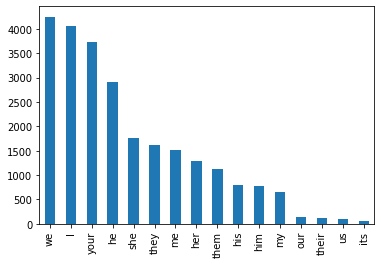

In [ ]:
#'we' as most frequent pronoun. (All data excluded 'you' and 'it')
df['X'].value_counts().plot(kind = 'bar')

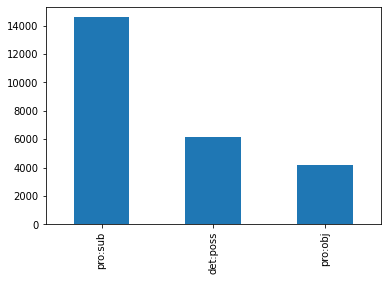

In [ ]:
#Nominative case as most frequent case.
df['X_tag'].value_counts().plot(kind = 'bar')

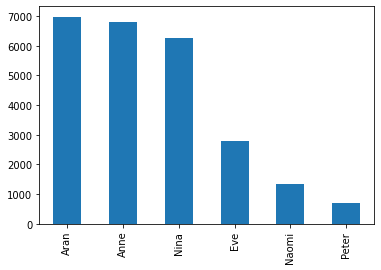

In [ ]:
#Different parents have different amount of samples
df['name'].value_counts().plot(kind = 'bar')

In [ ]:
#one-hot encoded aX, Xb and aXb
onehot_aX = pd.get_dummies(df.a)
onehot_Xb = pd.get_dummies(df.b)
onehot_aXb = pd.get_dummies(df.aXb)
df['onehot_aX'] = list(onehot_aX.values)
df['onehot_Xb'] = list(onehot_Xb.values)
df['onehot_aXb'] = list(onehot_aXb.values)

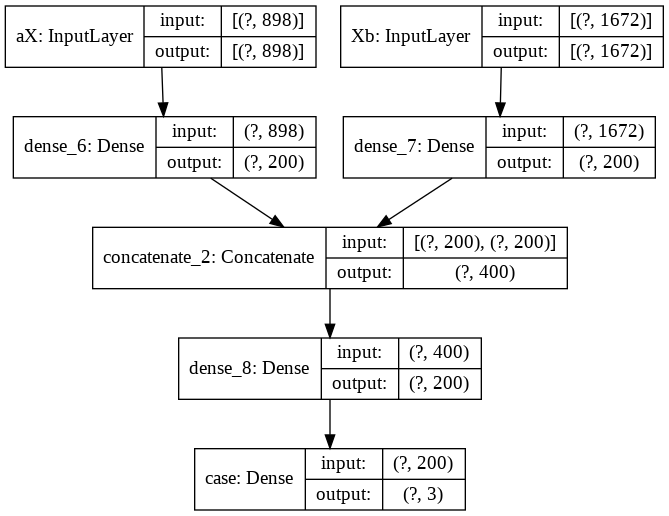

In [ ]:
#Training model for aX + Xb
aXshape = onehot_aX.shape[1]
bXshape = onehot_Xb.shape[1]
aX_input = keras.Input(shape=(aXshape,) , name ='aX')
Xb_input = keras.Input(shape=(bXshape,) ,name = 'Xb')
aX = layers.Dense(200, activation = 'relu')(aX_input)
Xb = layers.Dense(200, activation='relu')(Xb_input)
x = layers.concatenate([aX, Xb])
x = layers.Dense(200, activation = 'relu')(x)
case_pred = layers.Dense(3, name = 'case')(x)
model = keras.Model(
    inputs = [aX_input, Xb_input],
    outputs = case_pred)
keras.utils.plot_model(model, "aX + Xb model.png", show_shapes = True)


In [ ]:
#preparing data
aX = np.asarray(onehot_aX).astype(np.float32)
Xb = np.asarray(onehot_Xb).astype(np.float32)
aXb = np.asarray(onehot_aXb).astype(np.float32)
Y = np.asarray(df['encoded_case']).astype(np.float32)
X = {'aX': aX, 'Xb': Xb}

In [ ]:
#10fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle = False, random_state = 88)
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
trainindex = []
testindex = []
for train_index, test_index in kfold.split(aX, Y):
  print("Train:", train_index, "Test:", test_index)
  trainindex.append(train_index)
  testindex.append(test_index)

In [ ]:
#train the model with 10 fold 
#save the accuracy score 
#save the predicted case for each fold
aX_Xb_y_pred_kfold = []
aX_Xb_cvscores = []
for train, test in zip(trainindex, testindex): 
  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy', 'mse'])
  model.fit({"aX": aX[train], "Xb": Xb[train]}, 
            Y[train],
          validation_split = 0.2,
          callbacks=[early_stop, tfdocs.modeling.EpochDots()], 
          epochs=100,
          batch_size = 32)
  scores = model.evaluate({"aX": aX[test], "Xb": Xb[test]}, y={"case": Y[test]}, verbose=2)
  y_pred = model.predict([aX[test], Xb[test]])
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  aX_Xb_cvscores.append(scores[1] * 100)
  aX_Xb_y_pred_kfold.append(y_pred)

In [ ]:
print('aX+Xb accuracy for each fold:{}'.format(aX_Xb_cvscores))
print('aX+Xb accuracy average:{}'.format(sum(aX_Xb_cvscores)/len(aX_Xb_cvscores)))

aX+Xb accuracy for each fold:[96.3037371635437, 98.55363368988037, 98.83487224578857, 99.31699633598328, 99.5178759098053, 99.11611080169678, 99.35716986656189, 99.23664331436157, 97.06709384918213, 97.02572226524353]
aX+Xb accuracy average:98.43298554420471


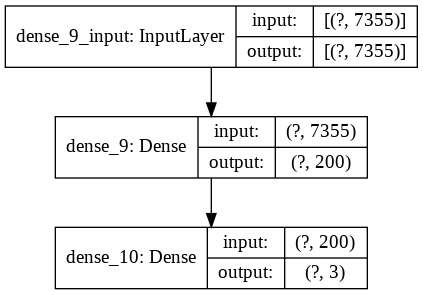

In [ ]:
#Model for aXb
model = keras.Sequential([
    layers.Dense(200, activation='relu', input_shape=[onehot_aXb.shape[1]]),
    layers.Dense(3)
  ])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','mse'])
keras.utils.plot_model(model, "aXb model.png", show_shapes = True)

In [ ]:
aXb_y_pred_kfold = []
aXb_cvscores = []
for train, test in zip(trainindex, testindex): 
  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy', 'mse'])
  model.fit(aXb[train], 
            Y[train],
          validation_split = 0.2,
          callbacks=[early_stop, tfdocs.modeling.EpochDots()], 
          epochs=100,
          batch_size = 32)
  scores = model.evaluate(aXb[test], Y[test], verbose=2)
  y_pred = model.predict(aXb[test])
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  aXb_cvscores.append(scores[1] * 100)
  aXb_y_pred_kfold.append(y_pred)

In [ ]:
print('aXb accuracy for each fold:{}'.format(aXb_cvscores))
print('aXb accuracy average:{}'.format(sum(aXb_cvscores)/len(aXb_cvscores)))

aXb accuracy for each fold:[85.93812584877014, 99.27681684494019, 99.07593131065369, 99.31699633598328, 99.59823489189148, 99.19646382331848, 99.47770237922668, 99.4375228881836, 91.56287908554077, 87.74116039276123]
aXb accuracy average:96.06218338012695


In [ ]:
aX_Xb_y_pred_case = []
aXb_y_pred_case = []
for i in aX_Xb_y_pred_kfold:
  y_i = np.argmax(i, axis = 1)
  aX_Xb_y_pred_case.append(y_i)
for w in range(0, 10):
  y = aXb_y_pred_kfold[w]
  y_k = np.argmax(y, axis = 1)
  aXb_y_pred_case.append(y_k)
print(aX_Xb_y_pred_case[1])
print(aXb_y_pred_case[1])

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [ ]:
dftestsum = []
for i in range(0,10):
  dftest = df.iloc[testindex[i]]
  dftest['pred_y_aX_Xb'] = aX_Xb_y_pred_case[i]
  dftest['pred_y_aXb'] = aXb_y_pred_case[i]
  dftest['fold'] = i
  dftestsum.append(dftest)
kfold = pd.concat(dftestsum)
kfold['aXb_correct'] = np.where((kfold['pred_y_aXb'] == kfold['encoded_case']) , 1, 0)
kfold['aX_Xb_correct'] = np.where((kfold['pred_y_aX_Xb'] == kfold['encoded_case']) , 1, 0)
kfold.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Unnamed: 0,file,a,a_tag,X,X_tag,b,b_tag,grammar cateogry,encode_cat,encode_pos,name,encoded_case,aXb,onehot_aX,onehot_Xb,onehot_aXb,pred_y_aX_Xb,pred_y_aXb,fold,aXb_correct,aX_Xb_correct
19161,20532,Anne/020301.xml,S,/s,I,pro:sub,don't,mod~neg,NOUN,6,84,Anne,2,S_don't,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,2,0,1,1
12379,15646,Anne/011104.xml,eating,part,them,pro:obj,E,/e,NOUN,6,72,Anne,1,eating_E,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,0,1,1
18979,14549,Nina/020524.xml,let,v,me,pro:obj,see,v,NOUN,6,72,Nina,1,let_see,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,0,1,1
9662,21107,Eve/010800.xml,on,prep,your,det:poss,stool,n,DET,4,25,Eve,0,on_stool,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,1,1
24807,8142,Nina/020212.xml,is,cop,his,det:poss,nose,n,DET,4,25,Nina,0,is_nose,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,1,1


In [ ]:
kfold.to_csv('aX+Xb_kfold_results.csv')
!cp aX+Xb_kfold_results.csv "/content/drive/My Drive/QP2/Input Model/"

In [ ]:
from sklearn import metrics
target_names = ['det:poss','pro:obj','pro:sub']
print('aXb classification')
print(metrics.classification_report(kfold['encoded_case'], kfold['pred_y_aXb'], digits=3, target_names=target_names))
print('aX+Xb classification')
print(metrics.classification_report(kfold['encoded_case'], kfold['pred_y_aX_Xb'], digits=3, target_names=target_names))

aXb classification
              precision    recall  f1-score   support

    det:poss      0.897     0.966     0.930      6156
     pro:obj      0.984     0.918     0.950      4152
     pro:sub      0.984     0.971     0.977     14581

    accuracy                          0.961     24889
   macro avg      0.955     0.951     0.952     24889
weighted avg      0.962     0.961     0.961     24889

aX+Xb classification
              precision    recall  f1-score   support

    det:poss      0.976     0.970     0.973      6156
     pro:obj      0.963     0.969     0.966      4152
     pro:sub      0.994     0.995     0.994     14581

    accuracy                          0.984     24889
   macro avg      0.978     0.978     0.978     24889
weighted avg      0.984     0.984     0.984     24889



#**Second Model with all unique aXb frames**(7355 samples)

In [ ]:
file = '/content/drive/My Drive/QP2/Input Model/df7355.csv'
df = pd.read_csv(file)
df = shuffle(df)
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,file,a,a_tag,X,X_tag,b,b_tag,grammar category,grammar cateogry,encode_cat,encode_pos,name,encoded_case,aXb,pred_y,pred_y_aXb,fold,correctaXb,correctaX+Xb
2580,5812,172099,172099,75176,Aran/020413.xml,than,prep,I,pro:sub,am,cop,unknown,NOUN,6,84,Aran,2,than_am,2,2,2,0,0
3908,10045,89134,89134,89134,Anne/020525.xml,are,cop,they,pro:sub,grapes,n,unknown,NOUN,6,84,Anne,2,are_grapes,2,2,4,0,0
3119,7467,46429,46429,46429,Anne/020122.xml,S,/s,they,pro:sub,fall,v,unknown,NOUN,6,84,Anne,2,S_fall,2,2,3,0,0
2358,5184,243113,243113,35386,Eve/020200a.xml,call,v,him,pro:obj,Fraser,n:prop,unknown,NOUN,6,72,Eve,1,call_Fraser,1,1,2,0,0
879,1445,240889,240889,33162,Eve/020100b.xml,how's,pro:int~cop,your,det:poss,foot,n,unknown,DET,4,25,Eve,0,how's_foot,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7355 entries, 2580 to 377
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        7355 non-null   int64 
 1   Unnamed: 0.1      7355 non-null   int64 
 2   Unnamed: 0.1.1    7355 non-null   int64 
 3   Unnamed: 0.1.1.1  7355 non-null   int64 
 4   file              7355 non-null   object
 5   a                 7355 non-null   object
 6   a_tag             7355 non-null   object
 7   X                 7355 non-null   object
 8   X_tag             7355 non-null   object
 9   b                 7355 non-null   object
 10  b_tag             7355 non-null   object
 11  grammar category  7355 non-null   object
 12  grammar cateogry  7355 non-null   object
 13  encode_cat        7355 non-null   int64 
 14  encode_pos        7355 non-null   int64 
 15  name              7355 non-null   object
 16  encoded_case      7355 non-null   int64 
 17  aXb         

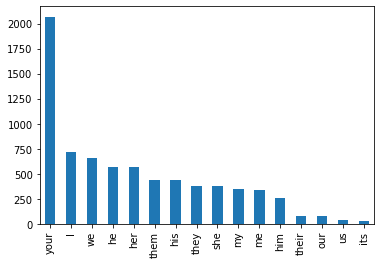

In [ ]:
df['X'].value_counts().plot(kind = 'bar')

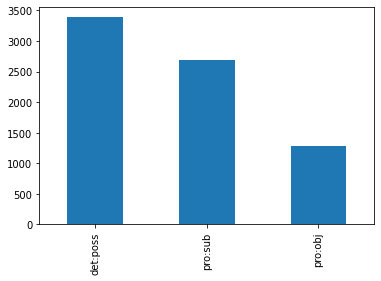

In [ ]:
df['X_tag'].value_counts().plot(kind = 'bar')

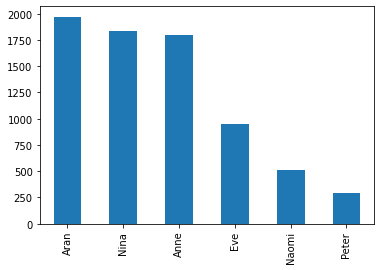

In [ ]:
df['name'].value_counts().plot(kind = 'bar')

In [ ]:
onehot_aX = pd.get_dummies(df.a)
onehot_Xb = pd.get_dummies(df.b)
onehot_aXb = pd.get_dummies(df.aXb)

In [ ]:
aXshape = onehot_aX.shape[1]
bXshape = onehot_Xb.shape[1]
aX_input = keras.Input(shape=(aXshape,) , name ='aX')
Xb_input = keras.Input(shape=(bXshape,) ,name = 'Xb')
aX = layers.Dense(200, activation = 'relu')(aX_input)
Xb = layers.Dense(200, activation='relu')(Xb_input)
x = layers.concatenate([aX, Xb])
x = layers.Dense(200, activation = 'relu')(x)
case_pred = layers.Dense(3, name = 'case')(x)
model = keras.Model(
    inputs = [aX_input, Xb_input],
    outputs = case_pred)

In [ ]:
aX = np.asarray(onehot_aX).astype(np.float32)
Xb = np.asarray(onehot_Xb).astype(np.float32)
aXb = np.asarray(onehot_aXb).astype(np.float32)
Y = np.asarray(df['encoded_case']).astype(np.float32)
X = {'aX': aX, 'Xb': Xb}

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle = False, random_state = 88)
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
trainindex = []
testindex = []
for train_index, test_index in kfold.split(aX, Y):
  print("Train:", train_index, "Test:", test_index)
  trainindex.append(train_index)
  testindex.append(test_index)

In [ ]:
aX_Xb_y_pred_kfold = []
aX_Xb_cvscores = []
for train, test in zip(trainindex, testindex): 
  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy', 'mse'])
  model.fit({"aX": aX[train], "Xb": Xb[train]}, 
            Y[train],
          validation_split = 0.2,
          callbacks=[early_stop, tfdocs.modeling.EpochDots()], 
          epochs=100,
          batch_size = 32)
  scores = model.evaluate({"aX": aX[test], "Xb": Xb[test]}, y={"case": Y[test]}, verbose=2)
  y_pred = model.predict([aX[test], Xb[test]])
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  aX_Xb_cvscores.append(scores[1] * 100)
  aX_Xb_y_pred_kfold.append(y_pred)


In [ ]:
print('aX+Xb accuracy for each fold:{}'.format(aX_Xb_cvscores))
print('aX+Xb accuracy average:{}'.format(sum(aX_Xb_cvscores)/len(aX_Xb_cvscores)))

aX+Xb accuracy for each fold:[89.8097813129425, 97.55434989929199, 98.9130437374115, 100.0, 99.728262424469, 100.0, 99.72789287567139, 100.0, 90.88435173034668, 90.20408391952515]
aX+Xb accuracy average:96.68217658996582


In [ ]:
model = keras.Sequential([
    layers.Dense(200, activation='relu', input_shape=[onehot_aXb.shape[1]]),
    layers.Dense(3)
  ])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','mse'])

In [ ]:
aXb_y_pred_kfold = []
aXb_cvscores = []
for train, test in zip(trainindex, testindex): 
  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy', 'mse'])
  model.fit(aXb[train], 
            Y[train],
          validation_split = 0.2,
          callbacks=[early_stop, tfdocs.modeling.EpochDots()], 
          epochs=100,
          batch_size = 32)
  scores = model.evaluate(aXb[test], Y[test], verbose=2)
  y_pred = model.predict(aXb[test])
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  aXb_cvscores.append(scores[1] * 100)
  aXb_y_pred_kfold.append(y_pred)

In [ ]:
print('aXb accuracy for each fold:{}'.format(aXb_cvscores))
print('aXb accuracy average:{}'.format(sum(aXb_cvscores)/len(aXb_cvscores)))

aXb accuracy for each fold:[45.38043439388275, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 56.46258592605591, 45.578232407569885]
aXb accuracy average:84.74212527275085


In [ ]:
aX_Xb_y_pred_case = []
aXb_y_pred_case = []
for i in aX_Xb_y_pred_kfold:
  y_i = np.argmax(i, axis = 1)
  aX_Xb_y_pred_case.append(y_i)
for w in range(0, 10):
  y = aXb_y_pred_kfold[w]
  y_k = np.argmax(y, axis = 1)
  aXb_y_pred_case.append(y_k)
print(aX_Xb_y_pred_case[1])
print(aXb_y_pred_case[1])


In [ ]:
dftestsum = []
for i in range(0,10):
  dftest = df.iloc[testindex[i]]
  dftest['pred_y_aX_Xb'] = aX_Xb_y_pred_case[i]
  dftest['pred_y_aXb'] = aXb_y_pred_case[i]
  dftest['fold'] = i
  dftestsum.append(dftest)
kfold = pd.concat(dftestsum)
kfold['aXb_correct'] = np.where((kfold['pred_y_aXb'] == kfold['encoded_case']) , 1, 0)
kfold['aX_Xb_correct'] = np.where((kfold['pred_y_aX_Xb'] == kfold['encoded_case']) , 1, 0)
kfold.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,file,a,a_tag,X,X_tag,b,b_tag,grammar category,grammar cateogry,encode_cat,encode_pos,name,encoded_case,aXb,pred_y,pred_y_aXb,fold,correctaXb,correctaX+Xb,pred_y_aX_Xb,aXb_correct,aX_Xb_correct
2580,5812,172099,172099,75176,Aran/020413.xml,than,prep,I,pro:sub,am,cop,unknown,NOUN,6,84,Aran,2,than_am,2,2,0,0,0,2,1,1
3908,10045,89134,89134,89134,Anne/020525.xml,are,cop,they,pro:sub,grapes,n,unknown,NOUN,6,84,Anne,2,are_grapes,2,0,0,0,0,2,0,1
3119,7467,46429,46429,46429,Anne/020122.xml,S,/s,they,pro:sub,fall,v,unknown,NOUN,6,84,Anne,2,S_fall,2,0,0,0,0,2,0,1
2358,5184,243113,243113,35386,Eve/020200a.xml,call,v,him,pro:obj,Fraser,n:prop,unknown,NOUN,6,72,Eve,1,call_Fraser,1,0,0,0,0,1,0,1
879,1445,240889,240889,33162,Eve/020100b.xml,how's,pro:int~cop,your,det:poss,foot,n,unknown,DET,4,25,Eve,0,how's_foot,0,0,0,0,0,0,1,1


In [ ]:
kfold.to_csv('kfold_few_results.csv')
!cp kfold_few_results.csv "/content/drive/My Drive/QP2/Input Model/"

In [ ]:
from sklearn import metrics
target_names = ['det:poss','pro:obj','pro:sub']
print('aXb classification')
print(metrics.classification_report(kfold['encoded_case'], kfold['pred_y_aXb'], digits=3, target_names=target_names))
print('aX+Xb classification')
print(metrics.classification_report(kfold['encoded_case'], kfold['pred_y_aX_Xb'], digits=3, target_names=target_names))

aXb classification
              precision    recall  f1-score   support

    det:poss      0.765     0.975     0.858      3386
     pro:obj      1.000     0.734     0.846      1281
     pro:sub      0.948     0.740     0.831      2688

    accuracy                          0.847      7355
   macro avg      0.904     0.817     0.845      7355
weighted avg      0.873     0.847     0.846      7355

aX+Xb classification
              precision    recall  f1-score   support

    det:poss      0.973     0.969     0.971      3386
     pro:obj      0.931     0.953     0.942      1281
     pro:sub      0.977     0.971     0.974      2688

    accuracy                          0.967      7355
   macro avg      0.960     0.964     0.962      7355
weighted avg      0.967     0.967     0.967      7355

